# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

## Loading the packages

In [2]:
import numpy as np
from keras.datasets import mnist
from keras.layers.core import Dense
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.utils import np_utils
from matplotlib import pyplot as pl
from skimage import exposure
from skimage.feature import hog
from sklearn import metrics as me

from utils import plot_confusion_matrix

%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Load the `mnist` dataset and normalize in the range [0, 1]

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [4]:
n_orientations = 8
pix_p_cell = 4
hog_size = int(height * width * n_orientations / (pix_p_cell * pix_p_cell))

In [5]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

Show the image and the corresponding gradients

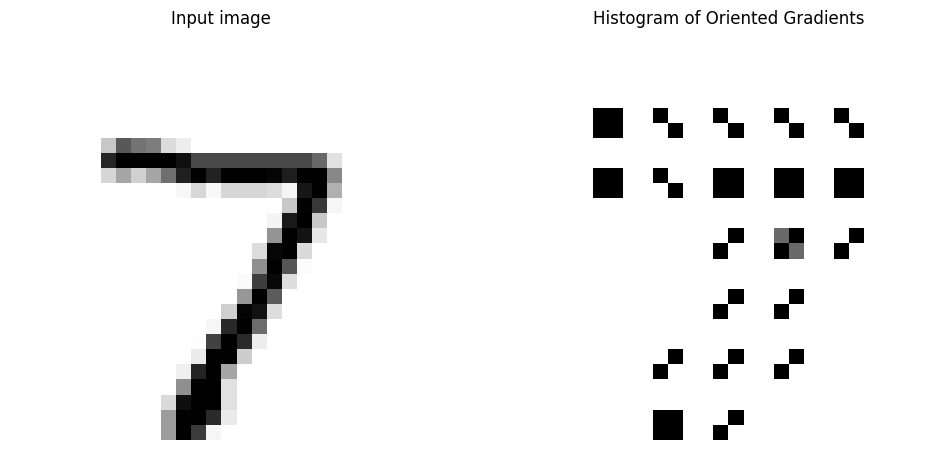

In [6]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')

Compute the HOGs for the train and test datasets

> Indented block



In [7]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_train done')

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_test done')

X_train done
X_test done


Create the MLP

In [8]:
model = Sequential()
model.add(Dense(200, input_shape=(hog_size,), activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               78600     
                                                                 
 dense_1 (Dense)             (None, 10)                2010      
                                                                 
Total params: 80,610
Trainable params: 80,610
Non-trainable params: 0
_________________________________________________________________


Define some constants and train the MLP

In [9]:
batch_size = 128
n_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

history = model.fit(X_train_hog, Y_train,
                    batch_size=batch_size, epochs=n_epoch,
                    verbose=1, validation_split=0.1)

Epoch 1/10
422/422 [==============================] - 1s 2ms/step - loss: 0.2383 - accuracy: 0.9436 - val_loss: 0.0868 - val_accuracy: 0.9743
Epoch 2/10
422/422 [==============================] - 1s 2ms/step - loss: 0.0942 - accuracy: 0.9703 - val_loss: 0.0754 - val_accuracy: 0.9755
Epoch 3/10
422/422 [==============================] - 1s 1ms/step - loss: 0.0781 - accuracy: 0.9749 - val_loss: 0.0705 - val_accuracy: 0.9778
Epoch 4/10
422/422 [==============================] - 1s 2ms/step - loss: 0.0684 - accuracy: 0.9778 - val_loss: 0.0647 - val_accuracy: 0.9793
Epoch 5/10
422/422 [==============================] - 1s 1ms/step - loss: 0.0600 - accuracy: 0.9808 - val_loss: 0.0655 - val_accuracy: 0.9792
Epoch 6/10
422/422 [==============================] - 1s 1ms/step - loss: 0.0531 - accuracy: 0.9832 - val_loss: 0.0637 - val_accuracy: 0.9795
Epoch 7/10
422/422 [==============================] - 1s 2ms/step - loss: 0.0472 - accuracy: 0.9854 - val_loss: 0.0656 - val_accuracy: 0.9797
Epoch 

Show the performance of the model

Test score: 0.06543819606304169
Test accuracy: 0.9800000190734863


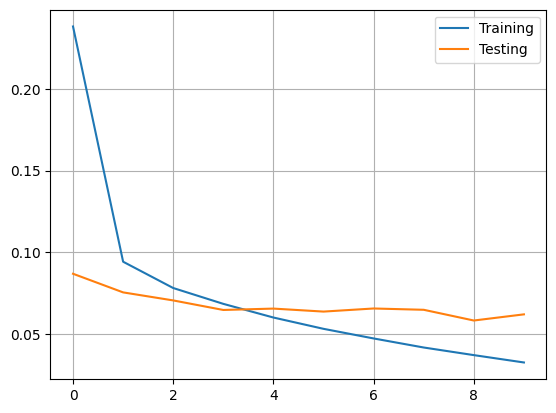

In [10]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test_hog, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

In [11]:
pred = np.argmax(model.predict(X_test_hog), axis=-1)
cm = me.confusion_matrix(y_test, pred)

plot_confusion_matrix(cm)

313/313 [==============================] - 0s 653us/step


array([[ 969,    0,    1,    0,    0,    2,    5,    1,    1,    1],
       [   1, 1128,    1,    1,    0,    2,    1,    0,    1,    0],
       [   2,    5, 1010,    1,    3,    0,    1,    3,    7,    0],
       [   0,    1,    5,  968,    0,   22,    1,    4,    9,    0],
       [   0,    3,    2,    0,  969,    0,    0,    1,    3,    4],
       [   1,    1,    0,    4,    0,  882,    3,    0,    1,    0],
       [   2,    2,    1,    0,    3,    2,  948,    0,    0,    0],
       [   0,    5,    7,    2,    4,    1,    0,  995,    5,    9],
       [   4,    0,    0,    2,    1,    1,    2,    5,  954,    5],
       [   0,    5,    1,    4,    7,    6,    0,    4,    5,  977]])